# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [2]:
# Set the run_code to test | run
run_code = 'run'

if run_code == 'run':
    dataset_path = '/kaggle/input/sncb-eda-data-clean/cleaned_ar41_for_ulb.csv'
else:
    dataset_path = '/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamps_UTC      object 
 1   mapped_veh_id       float64
 2   lat                 float64
 3   lon                 float64
 4   RS_E_InAirTemp_PC1  float64
 5   RS_E_InAirTemp_PC2  float64
 6   RS_E_OilPress_PC1   float64
 7   RS_E_OilPress_PC2   float64
 8   RS_E_RPM_PC1        float64
 9   RS_E_RPM_PC2        float64
 10  RS_E_WatTemp_PC1    float64
 11  RS_E_WatTemp_PC2    float64
 12  RS_T_OilTemp_PC1    float64
 13  RS_T_OilTemp_PC2    float64
 14  date                object 
 15  hour                float64
 16  dayofweek           float64
 17  weekday             object 
dtypes: float64(15), object(3)
memory usage: 2.4+ GB
None
        timestamps_UTC  mapped_veh_id        lat       lon  \
0  2023-01-23 07:25:08          102.0  51.017864  3.769079   
1  2023-01-23 07:25:16          102.0  51.0

In [3]:
data['lat'] = data['lat'].astype('float32')
data['lon'] = data['lon'].astype('float32')

# Speed Calculate

In [4]:
# if run_code == 'run':
#     # Convert timestamps to datetime format
#     data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

#     # Vectorize the distance calculation
#     def calculate_distances(lats, lons):
#         distances = np.zeros(len(lats))
#         for i in range(1, len(lats)):
#             if not np.isnan(lats[i]) and not np.isnan(lons[i]):
#                 distances[i] = geodesic((lats[i-1], lons[i-1]), (lats[i], lons[i])).kilometers
#         return distances

#     # Calculate distances using the vectorized function
#     latitudes = data['lat'].to_numpy()
#     longitudes = data['lon'].to_numpy()
#     data['Distance'] = calculate_distances(latitudes, longitudes)

#     # Calculate time intervals in hours
#     time_diffs = data['timestamps_UTC'].diff().dt.total_seconds() / 3600
#     time_diffs[0] = np.nan  # first element will be NaT after diff

#     # Calculate speeds in km/h
#     data['Speed'] = data['Distance'] / time_diffs

#     # Replace infinite values with NaN if division by zero occurred
#     data['Speed'].replace([np.inf, -np.inf], np.nan, inplace=True)

#     # Print the results
#     print(data[['timestamps_UTC', 'lat', 'lon', 'Distance', 'Speed']])
# else:
#     pass


In [5]:
# # Set 'Speed' to 0 where 'Speed' is greater than 120
# data.loc[data['Speed'] > 120, 'Speed'] = 0

In [6]:
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# # Moving Average to smooth data
# window_size = 5  
# data['lat_smooth'] = data['lat'].rolling(window=window_size).median()
# data['lon_smooth'] = data['lon'].rolling(window=window_size).median()

# Distance and Speed calculate function
def calculate_distances_and_speeds(data, min_interval=30):
    distances = np.zeros(len(data))
    speeds = np.zeros(len(data))
    previous_time = data['timestamps_UTC'].iloc[0]

    for i in range(1, len(data)):
        current_time = data['timestamps_UTC'].iloc[i]
        time_diff = (current_time - previous_time).total_seconds() / 3600  # change seconds to hours

        if time_diff >= min_interval / 3600:  # only when the interval larger than 30 seconds, we calculate the speed
            distance = geodesic((data['lat'].iloc[i-1], data['lon'].iloc[i-1]), 
                                (data['lat'].iloc[i], data['lon'].iloc[i])).kilometers
            speed = distance / time_diff if time_diff > 0 else 0
            distances[i] = distance
            speeds[i] = speed
            previous_time = current_time

    return distances, speeds

data['Distance'], data['Speed'] = calculate_distances_and_speeds(data)

In [7]:
# Handing outliers
speed_threshold = 120  # 120 km/h
data.loc[data['Speed'] > speed_threshold, 'Speed'] = np.nan

Interpelate

In [8]:
# Interpelate 
# Replace 0 with NaN in the whole dataset
data.replace(0, np.nan, inplace=True)

# Convert 'timestamps_UTC' to datetime, if not already done
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Check for NaN values in the index
if data.index.hasnans:
    raise ValueError("The index contains NaNs, which cannot be present for time interpolation.")

# Interpolate the NaN values in the whole dataset
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_cols] = data[numeric_cols].interpolate(method='time')

In [9]:
# Replace 0 with NaN in the whole dataset
data.replace(np.nan, 0, inplace=True)

# result
print(data[['lat', 'lon', 'Distance', 'Speed']])

                           lat       lon  Distance      Speed
timestamps_UTC                                               
2023-01-23 07:25:08  51.017864  3.769078  0.000000   0.000000
2023-01-23 07:25:16  51.017876  3.769046  0.000000   0.000000
2023-01-23 07:25:37  51.017208  3.770179  0.000000   0.000000
2023-01-23 07:25:41  51.016914  3.771036  0.068434   7.465564
2023-01-23 07:26:10  51.016502  3.772182  0.052601   6.287259
...                        ...       ...       ...        ...
2023-09-13 17:33:03  50.402695  4.450110  0.030669   1.811908
2023-09-13 17:33:58  50.401657  4.452693  0.211409  12.899178
2023-09-13 17:34:03  50.401829  4.452218  0.232337  14.176355
2023-09-13 17:34:58  50.401058  4.455389  0.207086  12.017265
2023-09-13 17:35:04  50.401085  4.455169  0.202145  11.643050

[17677337 rows x 4 columns]


In [10]:
# Change data type to reduce the data size
data['Distance'] = data['Distance'].astype('float32')
data['Speed'] = data['Speed'].astype('float32')

# Distribution of Distance

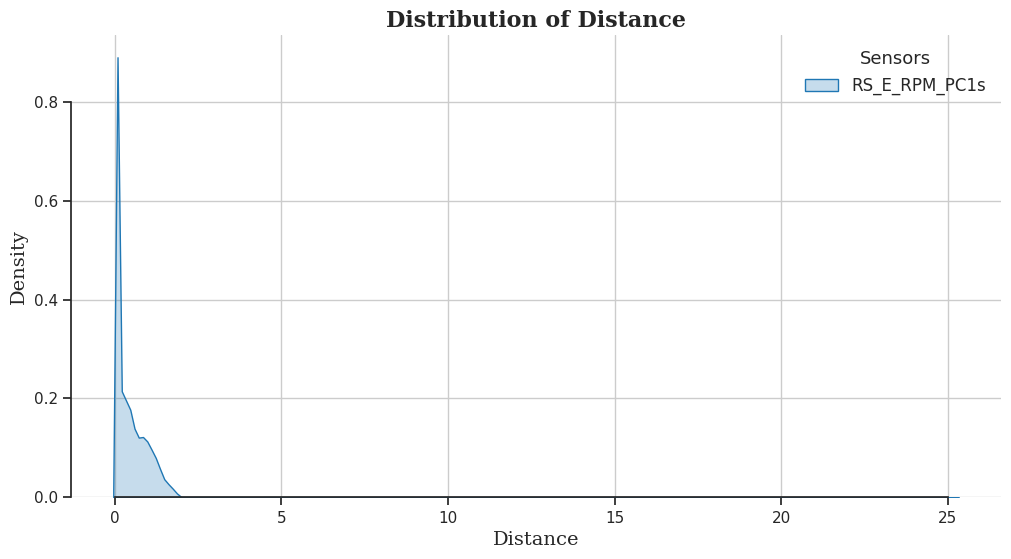

In [11]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['Distance'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)


# Adding titles and labels with a formal font type
plt.title('Distribution of Distance', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Distance', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of Speed

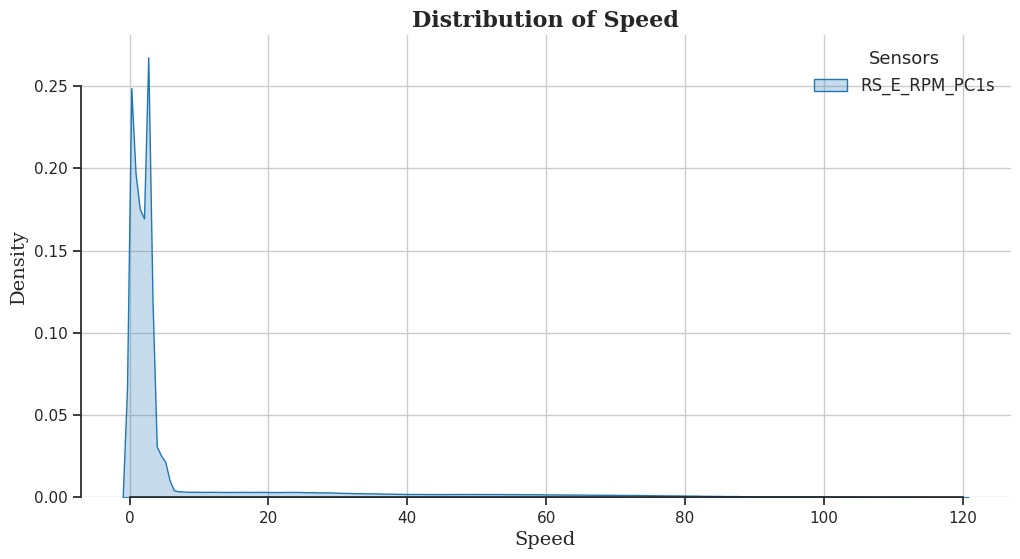

In [12]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['Speed'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)


# Adding titles and labels with a formal font type
plt.title('Distribution of Speed', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Speed', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

In [13]:
# get the column timestamps_UTC from index
data = data.reset_index()

# Weather Data

In [14]:
dataset_path = '/kaggle/input/weatherdataforsncb/WeatherData1213.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    weather_data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = weather_data.info()
    data_head = weather_data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11729693 entries, 0 to 11729692
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   datetime      object 
 1   lat           float64
 2   lon           float64
 3   weather_main  object 
 4   temp          float64
 5   feels_like    float64
 6   pressure      int64  
 7   humidity      int64  
 8   wind          float64
 9   clouds        int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 894.9+ MB
None
              datetime   lat   lon weather_main    temp  feels_like  pressure  \
0  2023-01-01 00:00:00  50.5  4.33        Clear  287.06      286.02      1012   
1  2023-01-01 01:00:00  50.5  4.33        Clear  287.03      285.99      1012   
2  2023-01-01 02:00:00  50.5  4.33        Clear  286.85      285.89      1013   
3  2023-01-01 03:00:00  50.5  4.33       Clouds  286.40      285.50      1013   
4  2023-01-01 04:00:00  50.5  4.33        Clear  286.23      285.37      1013   

   hu

In [15]:
# Remove duplicate rows from the weather_data dataframe
weather_data = weather_data.drop_duplicates()

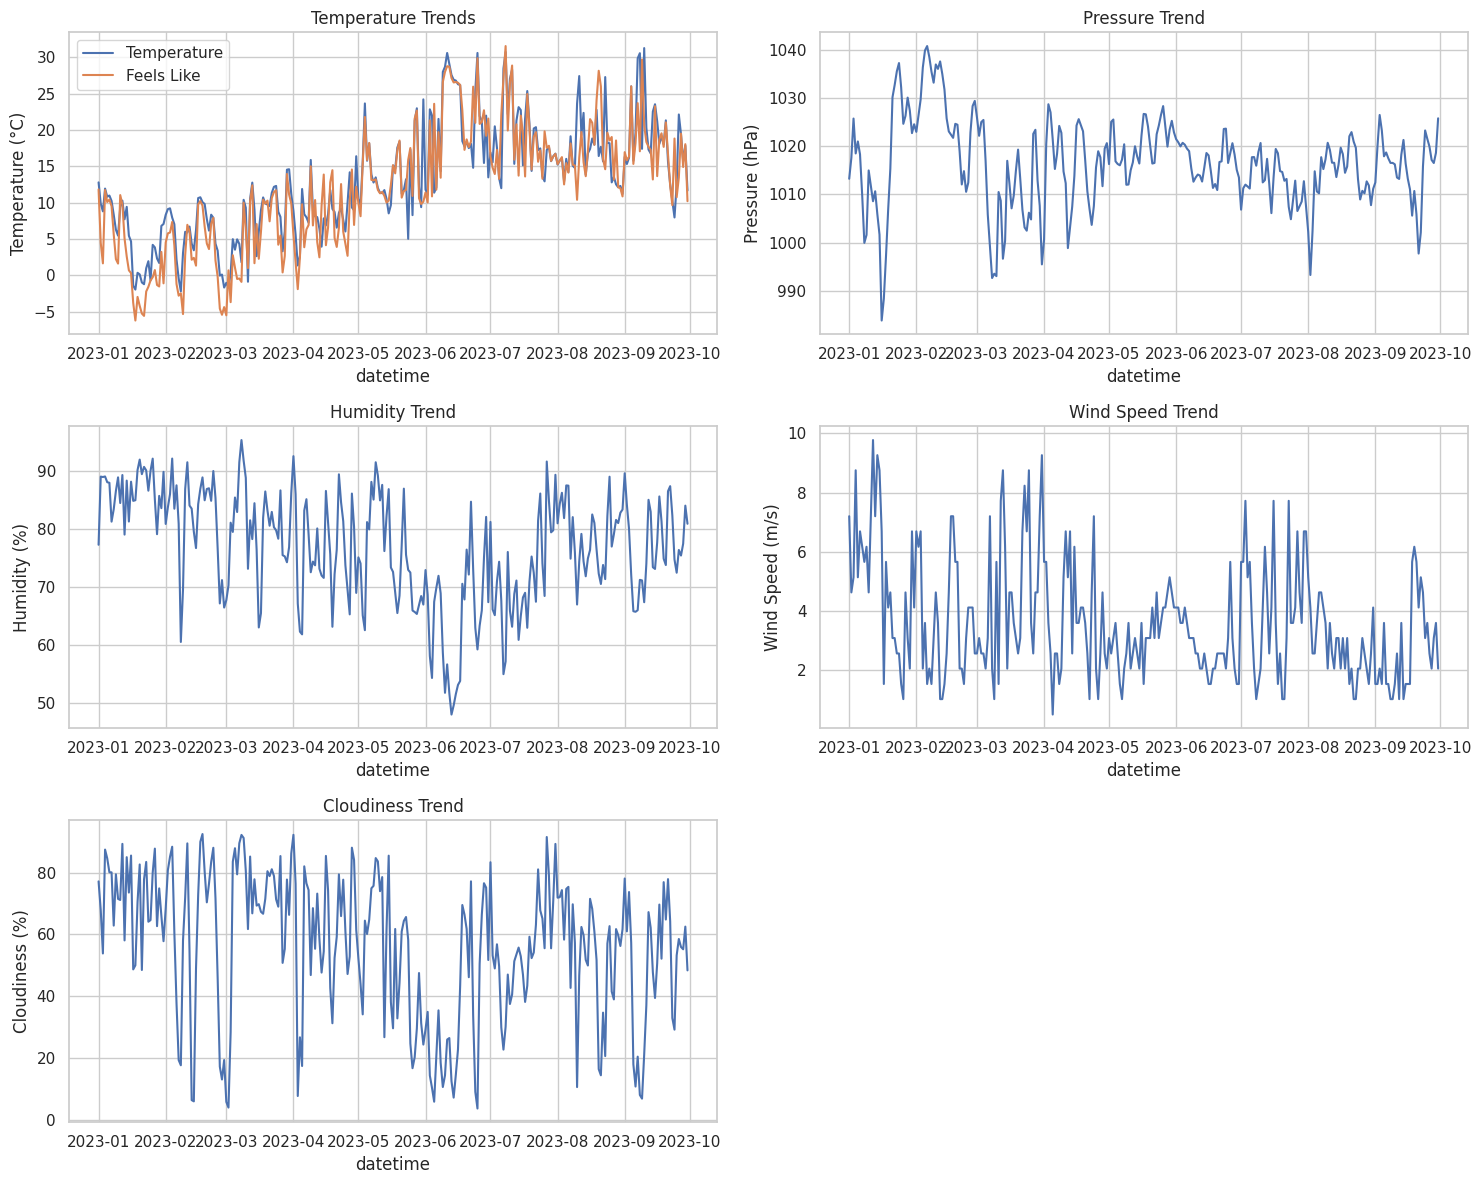

In [16]:
# Convert weather data from K to Celsius
weather_data['temp_celsius'] = weather_data['temp'] - 273.15
weather_data['feels_like_celsius'] = weather_data['feels_like'] - 273.15

# Convert 'datetime' to a datetime object
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Convert data types to reduce memory usage
for col in weather_data.select_dtypes(include=['float64']).columns:
    weather_data[col] = weather_data[col].astype('float32')

# Separate numeric and non-numeric columns
numeric_cols = weather_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = weather_data.select_dtypes(exclude=['float64', 'int64', 'datetime']).columns

# Resample numeric data to daily averages
daily_weather_data_numeric = weather_data.set_index('datetime')[numeric_cols].resample('D').mean()

# For non-numeric data, choose another aggregation method
daily_weather_data_non_numeric = weather_data.set_index('datetime')[non_numeric_cols].resample('D').agg(lambda x: x.mode()[0])

# Merge the resampled data back together
daily_weather_data = pd.merge(daily_weather_data_numeric, daily_weather_data_non_numeric, left_index=True, right_index=True)

# Set a style for the plots
sns.set(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Temperature trends
# sns.lineplot(x=daily_weather_data.index, y='temp', data=daily_weather_data, ax=axes[0, 0])
# sns.lineplot(x=daily_weather_data.index, y='feels_like', data=daily_weather_data, ax=axes[0, 0])
# axes[0, 0].set_title('Temperature Trends')
# axes[0, 0].set_ylabel('Temperature (K)')
# axes[0, 0].legend(['Temperature', 'Feels Like'])

# Temperature trends
sns.lineplot(x=daily_weather_data.index, y='temp_celsius', data=daily_weather_data, ax=axes[0, 0], label='Temperature')
sns.lineplot(x=daily_weather_data.index, y='feels_like_celsius', data=daily_weather_data, ax=axes[0, 0], label='Feels Like')
axes[0, 0].set_title('Temperature Trends')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].legend()

# Pressure trend
sns.lineplot(x=daily_weather_data.index, y='pressure', data=daily_weather_data, ax=axes[0, 1])
axes[0, 1].set_title('Pressure Trend')
axes[0, 1].set_ylabel('Pressure (hPa)')

# Humidity trend
sns.lineplot(x=daily_weather_data.index, y='humidity', data=daily_weather_data, ax=axes[1, 0])
axes[1, 0].set_title('Humidity Trend')
axes[1, 0].set_ylabel('Humidity (%)')

# Wind speed trend
sns.lineplot(x=daily_weather_data.index, y='wind', data=daily_weather_data, ax=axes[1, 1])
axes[1, 1].set_title('Wind Speed Trend')
axes[1, 1].set_ylabel('Wind Speed (m/s)')

# Cloudiness trend
sns.lineplot(x=daily_weather_data.index, y='clouds', data=daily_weather_data, ax=axes[2, 0])
axes[2, 0].set_title('Cloudiness Trend')
axes[2, 0].set_ylabel('Cloudiness (%)')

# Drop unused subplot
fig.delaxes(axes[2][1])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
# Basic statistics for each column
basic_statistics = daily_weather_data.describe()

basic_statistics

,pressure,humidity,clouds,lat,lon,temp,feels_like,wind,temp_celsius,feels_like_celsius
count,273.000000,273.000000,273.000000,273.000000,273.0,273.000000,273.000000,273.000000,273.000000,273.000000
mean,1016.381858,76.943871,56.096058,51.010002,4.4,286.158051,285.022095,3.629634,13.008060,11.872088
std,9.161711,9.683001,23.241245,0.000000,0.0,7.578143,8.424298,1.936821,7.578143,8.424298
min,983.823900,47.940754,3.704728,51.009998,4.4,270.920013,266.910004,0.510000,-2.230000,-6.240000
25%,1011.709691,70.541737,42.697355,51.009998,4.4,281.179993,278.910004,2.060000,8.030000,5.760000
50%,1016.542720,77.464209,60.617697,51.009998,4.4,285.320007,285.260010,3.090000,12.170000,12.110000
75%,1022.169733,84.937652,74.704518,51.009998,4.4,290.839996,290.839996,4.630000,17.690001,17.690001
max,1040.799649,95.389654,92.431742,51.009998,4.4,304.420013,304.700012,9.770000,31.270000,31.549999


# Merge Temperature Data

In [18]:
# Convert the timestamp columns to datetime objects and round lat/lon to two decimal places in both datasets
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

data['lat'] = data['lat'].round(2)
data['lon'] = data['lon'].round(2)
weather_data['lat'] = weather_data['lat'].round(2)
weather_data['lon'] = weather_data['lon'].round(2)

# Add a new column to both datasets for merging: date and hour (rounded to the nearest hour)
data['date_hour'] = data['timestamps_UTC'].dt.round('H')
weather_data['date_hour'] = weather_data['datetime'].dt.round('H')

# Merge the datasets on the new date_hour, lat, and lon columns
merged_data = pd.merge(data, weather_data, how='left', on=['date_hour', 'lat', 'lon'])
merged_data.head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,temp_celsius,feels_like_celsius
0,2023-01-23 07:25:08,102.0,51.02,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
1,2023-01-23 07:25:16,102.0,51.02,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
2,2023-01-23 07:25:37,102.0,51.02,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
3,2023-01-23 07:25:41,102.0,51.02,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4
4,2023-01-23 07:26:10,102.0,51.02,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.75,1035.0,92.0,2.52,100.0,1.39,-1.4


In [19]:
merged_data[merged_data['temp'].notnull()]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime,weather_main,temp,feels_like,pressure,humidity,wind,clouds,temp_celsius,feels_like_celsius
0,2023-01-23 07:25:08,102.0,51.020000,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
1,2023-01-23 07:25:16,102.0,51.020000,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
2,2023-01-23 07:25:37,102.0,51.020000,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
3,2023-01-23 07:25:41,102.0,51.020000,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
4,2023-01-23 07:26:10,102.0,51.020000,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,2023-01-23 07:00:00,Clouds,274.540009,271.750000,1035.0,92.0,2.52,100.0,1.39,-1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677332,2023-09-13 17:33:03,197.0,50.400002,4.45,37.0,40.0,220.0,258.0,803.0,803.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677333,2023-09-13 17:33:58,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,843.0,941.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677334,2023-09-13 17:34:03,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,841.0,932.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07
17677335,2023-09-13 17:34:58,197.0,50.400002,4.46,36.0,38.0,207.0,244.0,800.0,803.0,...,2023-09-13 18:00:00,Clouds,290.380005,290.220001,1021.0,79.0,3.60,20.0,17.23,17.07


# Air Quality Data

In [20]:
dataset_path = '/kaggle/input/airqualitydata/airQuality.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    air_data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = air_data.info()
    data_head = air_data.head()

    # If you want to print the information to the console
    print(air_data)
    print(air_data)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11534400 entries, 0 to 11534399
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   datetime  object 
 1   lat       float64
 2   lon       float64
 3   aqi       int64  
 4   co        float64
 5   no        float64
 6   no2       float64
 7   o3        float64
 8   so2       float64
 9   pm2_5     float64
 10  pm10      float64
 11  nh3       float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.0+ GB
                     datetime    lat   lon  aqi      co    no    no2     o3  \
0         2023-01-01 01:00:00  50.77  3.87    2  216.96  0.00   2.48  66.52   
1         2023-01-01 02:00:00  50.77  3.87    2  208.62  0.00   1.82  67.95   
2         2023-01-01 03:00:00  50.77  3.87    2  203.61  0.00   1.54  68.66   
3         2023-01-01 04:00:00  50.77  3.87    2  203.61  0.00   1.44  69.38   
4         2023-01-01 05:00:00  50.77  3.87    2  201.94  0.00   1.46  68.66   
...                       

In [21]:
# Remove duplicate rows from the weather_data dataframe
air_data = air_data.drop_duplicates()
air_data

,datetime,lat,lon,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 01:00:00,50.77,3.87,2,216.96,0.00,2.48,66.52,0.81,5.32,8.69,1.61
1,2023-01-01 02:00:00,50.77,3.87,2,208.62,0.00,1.82,67.95,0.63,5.20,8.25,1.63
2,2023-01-01 03:00:00,50.77,3.87,2,203.61,0.00,1.54,68.66,0.59,5.09,7.45,1.58
3,2023-01-01 04:00:00,50.77,3.87,2,203.61,0.00,1.44,69.38,0.59,4.95,6.71,1.50
4,2023-01-01 05:00:00,50.77,3.87,2,201.94,0.00,1.46,68.66,0.62,4.50,5.77,1.42
...,...,...,...,...,...,...,...,...,...,...,...,...
11534395,2023-09-29 20:00:00,50.82,4.29,2,320.43,1.87,40.10,6.44,1.91,6.38,9.66,5.19
11534396,2023-09-29 21:00:00,50.82,4.29,1,320.43,5.31,35.30,1.12,1.73,6.67,10.22,7.22
11534397,2023-09-29 22:00:00,50.82,4.29,1,297.07,4.25,28.10,1.31,1.13,6.32,9.93,8.49
11534398,2023-09-29 23:00:00,50.82,4.29,1,280.38,1.72,21.93,2.86,0.63,6.38,9.79,5.83


In [22]:
# # Identify numeric and non-numeric columns
# numeric_cols = air_data.select_dtypes(include=['float64', 'int64']).columns
# non_numeric_cols = air_data.select_dtypes(exclude=['float64', 'int64', 'datetime']).columns

# # Resample numeric data to daily averages
# daily_merged_data_numeric = air_data.set_index('datetime')[numeric_cols].resample('D').mean()

# # For non-numeric data, use mode as an aggregation method
# daily_merged_data_non_numeric = air_data.set_index('datetime')[non_numeric_cols].resample('D').agg(lambda x: x.mode()[0])

# # Merge the resampled data back together
# daily_merged_data = pd.merge(daily_merged_data_numeric, daily_merged_data_non_numeric, left_index=True, right_index=True)

# # Visualization
# sns.set(style="whitegrid")

# # Example: Create a figure with multiple subplots for different air quality indices
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# # AQI trend
# sns.lineplot(x=daily_merged_data.index, y='aqi', data=daily_merged_data, ax=axes[0, 0])
# axes[0, 0].set_title('AQI Trend')

# # CO trend
# sns.lineplot(x=daily_merged_data.index, y='co', data=daily_merged_data, ax=axes[0, 1])
# axes[0, 1].set_title('CO Trend')

# # NO2 trend
# sns.lineplot(x=daily_merged_data.index, y='no2', data=daily_merged_data, ax=axes[1, 0])
# axes[1, 0].set_title('NO2 Trend')

# # O3 trend
# sns.lineplot(x=daily_merged_data.index, y='o3', data=daily_merged_data, ax=axes[1, 1])
# axes[1, 1].set_title('O3 Trend')

# # SO2 trend
# sns.lineplot(x=daily_merged_data.index, y='so2', data=daily_merged_data, ax=axes[2, 0])
# axes[2, 0].set_title('SO2 Trend')

# # PM2.5 trend
# sns.lineplot(x=daily_merged_data.index, y='pm2_5', data=daily_merged_data, ax=axes[2, 1])
# axes[2, 1].set_title('PM2.5 Trend')

# # Adjust layout and show plots
# plt.tight_layout()
# plt.show()

# Merge Air Data

In [23]:
# Convert the timestamp column to a datetime object
merged_data['timestamps_UTC'] = pd.to_datetime(merged_data['timestamps_UTC'])
air_data['datetime'] = pd.to_datetime(air_data['datetime'])

# Round lat/lon to two decimal places
merged_data['lat'] = merged_data['lat'].round(2)
merged_data['lon'] = merged_data['lon'].round(2)
air_data['lat'] = air_data['lat'].round(2)
air_data['lon'] = air_data['lon'].round(2)

# Add a new column for merging: date and hour (rounded to the nearest hour)
# Add a new column to both datasets for merging: date and hour (rounded to the nearest hour)
merged_data['date_hour'] = merged_data['timestamps_UTC'].dt.round('H')
air_data['date_hour'] = air_data['datetime'].dt.round('H')

# Merge the datasets on the 'date_hour', 'lat', and 'lon' columns
final_merged_data = pd.merge(merged_data, air_data, how='left', on=['date_hour', 'lat', 'lon'])

# Display the first few rows of the merged dataset
final_merged_data.head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime_y,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-23 07:25:08,102.0,51.02,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23 07:25:16,102.0,51.02,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-23 07:25:37,102.0,51.02,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-23 07:25:41,102.0,51.02,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-23 07:26:10,102.0,51.02,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
final_merged_data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime_y,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-23 07:25:08,102.0,51.020000,3.77,17.0,18.0,210.0,210.0,858.0,839.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23 07:25:16,102.0,51.020000,3.77,17.0,20.0,200.0,200.0,801.0,804.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-23 07:25:37,102.0,51.020000,3.77,19.0,20.0,193.0,207.0,803.0,808.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-23 07:25:41,102.0,51.020000,3.77,19.0,20.0,196.0,203.0,801.0,803.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-23 07:26:10,102.0,51.020000,3.77,19.0,21.0,200.0,203.0,795.0,807.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677332,2023-09-13 17:33:03,197.0,50.400002,4.45,37.0,40.0,220.0,258.0,803.0,803.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17677333,2023-09-13 17:33:58,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,843.0,941.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17677334,2023-09-13 17:34:03,197.0,50.400002,4.45,37.0,38.0,224.0,307.0,841.0,932.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17677335,2023-09-13 17:34:58,197.0,50.400002,4.46,36.0,38.0,207.0,244.0,800.0,803.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
final_merged_data[final_merged_data['pm2_5'].notnull()]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,datetime_y,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
210560,2023-01-23 09:20:37,103.0,50.5,4.25,28.0,32.0,210.0,200.0,798.0,805.0,...,2023-01-23 09:00:00,2.0,340.46,2.04,31.53,4.43,3.37,10.91,13.28,1.27
223173,2023-02-14 09:11:29,103.0,50.5,4.25,34.0,35.0,238.0,213.0,802.0,800.0,...,2023-02-14 09:00:00,3.0,447.27,16.09,32.22,11.18,2.59,41.80,44.49,5.32
225003,2023-02-16 07:52:55,103.0,50.5,4.25,25.0,18.0,445.0,424.0,1674.0,1726.0,...,2023-02-16 08:00:00,3.0,377.18,0.09,21.42,30.76,2.15,29.78,31.84,3.04
225084,2023-02-16 09:12:52,103.0,50.5,4.25,35.0,34.0,231.0,210.0,801.0,803.0,...,2023-02-16 09:00:00,3.0,357.15,0.44,18.68,34.33,2.15,27.23,29.17,2.98
235249,2023-03-03 11:51:31,103.0,50.5,4.25,15.0,9.0,403.0,379.0,1373.0,1290.0,...,2023-03-03 12:00:00,2.0,307.08,4.02,21.93,35.41,3.87,19.77,21.73,11.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17628342,2023-07-18 14:52:57,197.0,50.5,4.25,40.0,44.0,365.0,441.0,1907.0,1915.0,...,2023-07-18 15:00:00,3.0,186.92,0.25,1.30,104.43,0.72,3.43,4.52,2.79
17646042,2023-08-01 18:54:12,197.0,50.5,4.25,38.0,35.0,376.0,465.0,1921.0,1927.0,...,2023-08-01 19:00:00,2.0,236.99,0.02,4.03,61.51,1.27,3.58,4.58,2.37
17646043,2023-08-01 18:54:17,197.0,50.5,4.25,38.0,36.0,372.0,469.0,1923.0,1929.0,...,2023-08-01 19:00:00,2.0,236.99,0.02,4.03,61.51,1.27,3.58,4.58,2.37
17656748,2023-08-16 06:51:40,197.0,50.5,4.25,41.0,37.0,369.0,472.0,1914.0,1925.0,...,2023-08-16 07:00:00,2.0,280.38,2.18,30.16,20.56,3.76,12.40,14.61,2.41


# Save to CSV

In [26]:
final_merged_data.to_csv('augumented_cleaned_ar41_for_ulb.csv', index=True)